In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import xskillscore as xs
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.cm as mpl_cm
from eofs.xarray import Eof

# Fog Data

In [6]:
fogData = xr.open_dataset('../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-12-1','2018-1-31'))
yAll=yAll/25.0
yWd= yAll[yAll >0.44]
#yWd

# 500 z Data

In [7]:
z500Data = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')
z500Data
z=z500Data.z.shift(time=1)
z.values=z.values/9.81
#z
z

<xarray.DataArray 'z' (time: 3772, latitude: 46, longitude: 180)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[5129.0015, 5129.0015, 5129.0015, ..., 5129.0015, 5129.0015,
         5129.0015],
        [5084.0093, 5081.8154, 5079.643 , ..., 5090.592 , 5088.3755,
         5086.181 ],
        [5048.658 , 5044.0264, 5039.394 , ..., 5062.2   , 5057.5903,
         5053.1353],
...
        [5863.128 , 5862.906 , 5863.748 , ..., 5863.704 , 5863.46  ,
         5863.482 ],
        [5863.571 , 5864.5684, 5862.7065, ..., 5864.1694, 5863.3716,
         5863.2607],
        [5862.64  , 5863.039 , 5865.189 , ..., 5864.6567, 5863.5483,
         5863.9697]],

       [[4955.615 , 4955.615 , 4955.615 , ..., 4955.615 , 4955.615 ,
         4955.615 ],
        [4976.2056, 4977.1143, 4977.9565, ..., 4973.1025, 4974.1885,
         4975.2524],
        [4995.931 , 4997.2827, 4998.4575, ..., 4990.922 , 4992.5845,
         4994.313 ],
        ...,
        [5861.576 , 5862.64  , 5862.773 , ..., 5858.939 , 5860.6455,
         5861.    ],
        [5863.659 , 5863.1943, 5863.1943, ..., 5860.224 , 5861.133 ,
         5861.8867],
        [5865.167 , 5864.546 , 5864.7456, ..., 5861.31  , 5862.884 ,
         5864.147 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
Attributes:
    standard_name:  geopotential
    long_name:      Geopotential
    units:          m**2 s**-2

# Calculate daily Anomaly

In [8]:
da = z.assign_coords(month_day=z.time.dt.strftime("%m-%d"))
dailyAnomZ = da.groupby("month_day") - da.groupby("month_day").mean("time")
decJanAnomz=dailyAnomZ[(dailyAnomZ.time.dt.month>11) | (dailyAnomZ.time.dt.month<2)].sel(time=slice('1980-12-1','2018-1-31'))
yAll['time'] = decJanAnomz.time
da

<xarray.DataArray 'z' (time: 3772, latitude: 46, longitude: 180)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[5129.0015, 5129.0015, 5129.0015, ..., 5129.0015, 5129.0015,
         5129.0015],
        [5084.0093, 5081.8154, 5079.643 , ..., 5090.592 , 5088.3755,
         5086.181 ],
        [5048.658 , 5044.0264, 5039.394 , ..., 5062.2   , 5057.5903,
         5053.1353],
...
        [5863.128 , 5862.906 , 5863.748 , ..., 5863.704 , 5863.46  ,
         5863.482 ],
        [5863.571 , 5864.5684, 5862.7065, ..., 5864.1694, 5863.3716,
         5863.2607],
        [5862.64  , 5863.039 , 5865.189 , ..., 5864.6567, 5863.5483,
         5863.9697]],

       [[4955.615 , 4955.615 , 4955.615 , ..., 4955.615 , 4955.615 ,
         4955.615 ],
        [4976.2056, 4977.1143, 4977.9565, ..., 4973.1025, 4974.1885,
         4975.2524],
        [4995.931 , 4997.2827, 4998.4575, ..., 4990.922 , 4992.5845,
         4994.313 ],
        ...,
        [5861.576 , 5862.64  , 5862.773 , ..., 5858.939 , 5860.6455,
         5861.    ],
        [5863.659 , 5863.1943, 5863.1943, ..., 5860.224 , 5861.133 ,
         5861.8867],
        [5865.167 , 5864.546 , 5864.7456, ..., 5861.31  , 5862.884 ,
         5864.147 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
    month_day  (time) object '01-01' '01-02' '01-03' ... '12-29' '12-30' '12-31'
Attributes:
    standard_name:  geopotential
    long_name:      Geopotential
    units:          m**2 s**-2

In [9]:
# get WFD daily anomaly
wfdZ=decJanAnomz[yAll >0.44,:,:]
wfdZ.time

<xarray.DataArray 'time' (time: 588)>
array(['1983-01-04T09:00:00.000000000', '1983-01-05T09:00:00.000000000',
       '1983-01-06T09:00:00.000000000', ..., '2018-01-27T09:00:00.000000000',
       '2018-01-28T09:00:00.000000000', '2018-01-29T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1983-01-04T09:00:00 ... 2018-01-29T09:00:00
    month_day  (time) object '01-04' '01-05' '01-06' ... '01-27' '01-28' '01-29'
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

#  Composite anomaly for widespread fog days

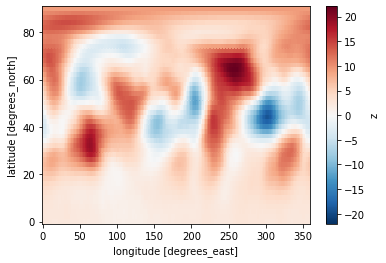

In [10]:
# Get Composite anomoaly for fog days
wfdComp=wfdZ.mean(dim="time")
wfdComp.plot()


In [11]:
wfdZComp_cube=wfdComp.to_iris()
wfdZComp_cube
wfdZComp_cube_small=wfdComp.sel(latitude=slice(33,24),longitude=slice(72,87)).to_iris()
wfdZComp_cube_small

Z (unknown),latitude,longitude
Shape,5,8
Dimension coordinates,,
latitude,x,-
longitude,-,x


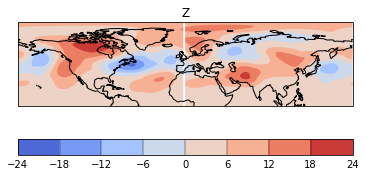

In [12]:
# Load a Cynthia Brewer palette.
brewer_cmap = mpl_cm.get_cmap("brewer_PuOr_11")

# Draw the contours, with n-levels set for the map colours (9).
# NOTE: needed as the map is non-interpolated, but matplotlib does not provide
# any special behaviour for these.
qplt.contourf(wfdZComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

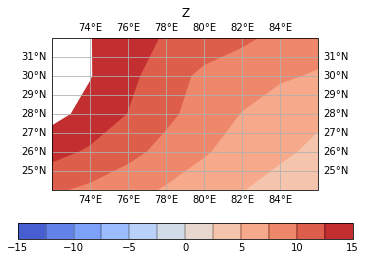

In [13]:
# Load a Cynthia Brewer palette.
brewer_cmap = mpl_cm.get_cmap("brewer_PuOr_11")

# Draw the contours, with n-levels set for the map colours (9).
# NOTE: needed as the map is non-interpolated, but matplotlib does not provide
# any special behaviour for these.
levels = (-15,-12.5,-10,-7.5,-5, -2.5,0,2.5,5,7.5,10,12.5,15)

qplt.contourf(wfdZComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

plt.show()

#  EOFS

In [41]:
# get WFD daily anomaly
wfdZ=decJanAnomz.sel(latitude=slice(40,20),longitude=slice(60,85))[yAll >0.44,:,:]
solver = Eof(wfdZ)

# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
#eof = solver.eofsAsCovariance(neofs=10)
eof = solver.eofs(neofs=10)
eof


variance_fractions = solver.varianceFraction(neigs=10)
print(variance_fractions.sum())
print(variance_fractions)


<xarray.DataArray 'variance_fractions' ()>
array(0.99315697, dtype=float32)
<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.59403664, 0.18224841, 0.12911963, 0.03712029, 0.02040678,
       0.01625429, 0.00518922, 0.00415388, 0.00297452, 0.00165332],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions


In [42]:
eof[0,:,:]

<xarray.DataArray 'eofs' (latitude: 11, longitude: 13)>
array([[0.06840163, 0.07873832, 0.08828431, 0.09521623, 0.09933616,
        0.10051289, 0.09960113, 0.0973663 , 0.09671374, 0.09529696,
        0.09305149, 0.0901715 , 0.08717752],
       [0.08390691, 0.09440762, 0.10331966, 0.10962527, 0.11293382,
        0.11261883, 0.10850607, 0.10564394, 0.10277787, 0.10076214,
        0.09725858, 0.09361555, 0.09023846],
       [0.09539124, 0.10423693, 0.11205663, 0.11675842, 0.11940123,
        0.11839794, 0.11424399, 0.10999143, 0.10832615, 0.10426614,
        0.10097121, 0.09731442, 0.09312367],
       [0.09958821, 0.10782555, 0.11446227, 0.11910726, 0.1213787 ,
        0.12080953, 0.11738187, 0.1113118 , 0.10643013, 0.10261277,
        0.09747765, 0.09383199, 0.08964373],
       [0.09747569, 0.10507197, 0.11095735, 0.11536986, 0.11782299,
        0.1181703 , 0.11545187, 0.1096198 , 0.1008154 , 0.09597559,
        0.09300067, 0.0886355 , 0.08422478],
       [0.0894166 , 0.09550717, 0.10049196, 0.10466537, 0.10549302,
        0.10677735, 0.1050844 , 0.10102806, 0.09452473, 0.08711462,
        0.07839013, 0.07392635, 0.07032032],
       [0.07695835, 0.08193607, 0.0855737 , 0.08832264, 0.08984929,
        0.09066616, 0.08944728, 0.08687823, 0.08252928, 0.07715289,
        0.07101465, 0.06366879, 0.05831559],
       [0.06146929, 0.06477109, 0.06785198, 0.07077698, 0.07214145,
        0.07261702, 0.07211041, 0.07032888, 0.06734484, 0.06358852,
        0.05888371, 0.05365767, 0.04838902],
       [0.0456841 , 0.04835403, 0.05089004, 0.05287645, 0.05413449,
        0.05463047, 0.05442889, 0.05346935, 0.05163438, 0.04871325,
        0.04543323, 0.04156018, 0.03753421],
       [0.03162908, 0.03367294, 0.03548913, 0.03711224, 0.03827079,
        0.03891409, 0.03881078, 0.03848062, 0.03723677, 0.03520254,
        0.03288241, 0.02998793, 0.02725714],
       [0.02019739, 0.02160101, 0.02314215, 0.02456835, 0.02574005,
        0.02631178, 0.02657838, 0.02641205, 0.02556308, 0.02434317,
        0.02280089, 0.02096586, 0.01913796]], dtype=float32)
Coordinates:
    mode       int64 0
  * latitude   (latitude) float32 40.0 38.0 36.0 34.0 ... 26.0 24.0 22.0 20.0
  * longitude  (longitude) float32 60.0 62.0 64.0 66.0 ... 78.0 80.0 82.0 84.0
Attributes:
    long_name:  empirical_orthogonal_functions

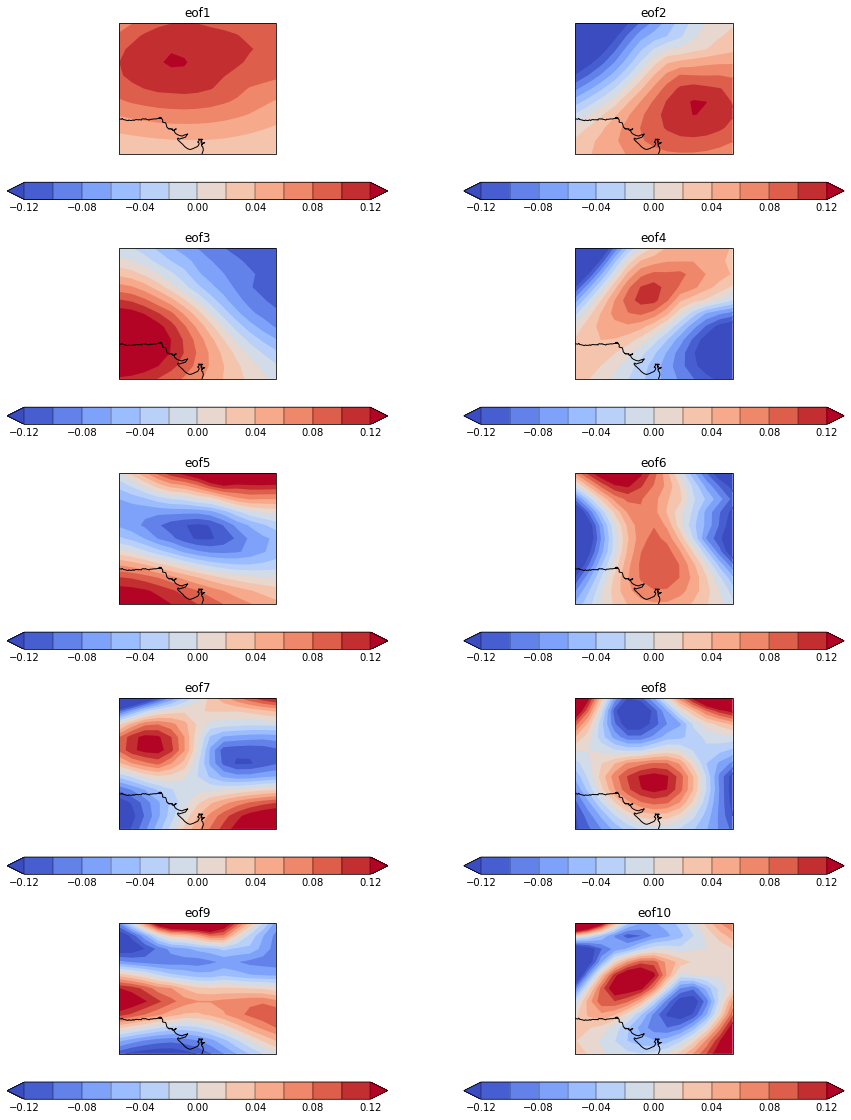

<iris 'Cube' of empirical_orthogonal_functions / (unknown) (latitude: 11; longitude: 13)>

In [43]:
# plot eofs
#levels = (-4,-3,-2,-1.5,-1, -0.5,0,0.5,1,1.5,2,3,4)
levels = (-0.12,-0.1,-0.08,-0.06,-0.04, -0.02,0,0.02,0.04,0.06,0.08,.1,0.12)
# Plot #1: contourf with axes longitude from -180 to 180
eof1=eof[0,:,:].to_iris()
plt.figure(figsize=(15,20))
plt.subplot(521)
qplt.contourf(eof1,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof1")

eof2=eof[1,:,:].to_iris()
plt.subplot(522)
qplt.contourf(eof2, cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof2")


eof3=eof[2,:,:].to_iris()
plt.subplot(523)
qplt.contourf(eof3,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof3")

eof4=eof[3,:,:].to_iris()
plt.subplot(524)
qplt.contourf(eof4,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof4")

eof5=eof[4,:,:].to_iris()
plt.subplot(525)
qplt.contourf(eof5,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof5")

eof6=eof[5,:,:].to_iris()
plt.subplot(526)
qplt.contourf(eof6,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof6")


eof7=eof[6,:,:].to_iris()
plt.subplot(527)
qplt.contourf(eof7,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof7")

eof8=eof[7,:,:].to_iris()
plt.subplot(528)
qplt.contourf(eof8, cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof8")


eof9=eof[8,:,:].to_iris()
plt.subplot(529)
qplt.contourf(eof9,  cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof9")

eof10=eof[9,:,:].to_iris()
plt.subplot(5,2,10)
qplt.contourf(eof10, cmap='coolwarm',levels=levels,extend='both')
plt.gca().coastlines()
plt.title("eof10")


iplt.show()

eof1


# EOF2

<xarray.DataArray 'variance_fractions' ()>
array(0.9718467, dtype=float32)
<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.44410798, 0.20390438, 0.12986512, 0.08232331, 0.04258297,
       0.02397471, 0.01675572, 0.01193169, 0.00908089, 0.00731998],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions


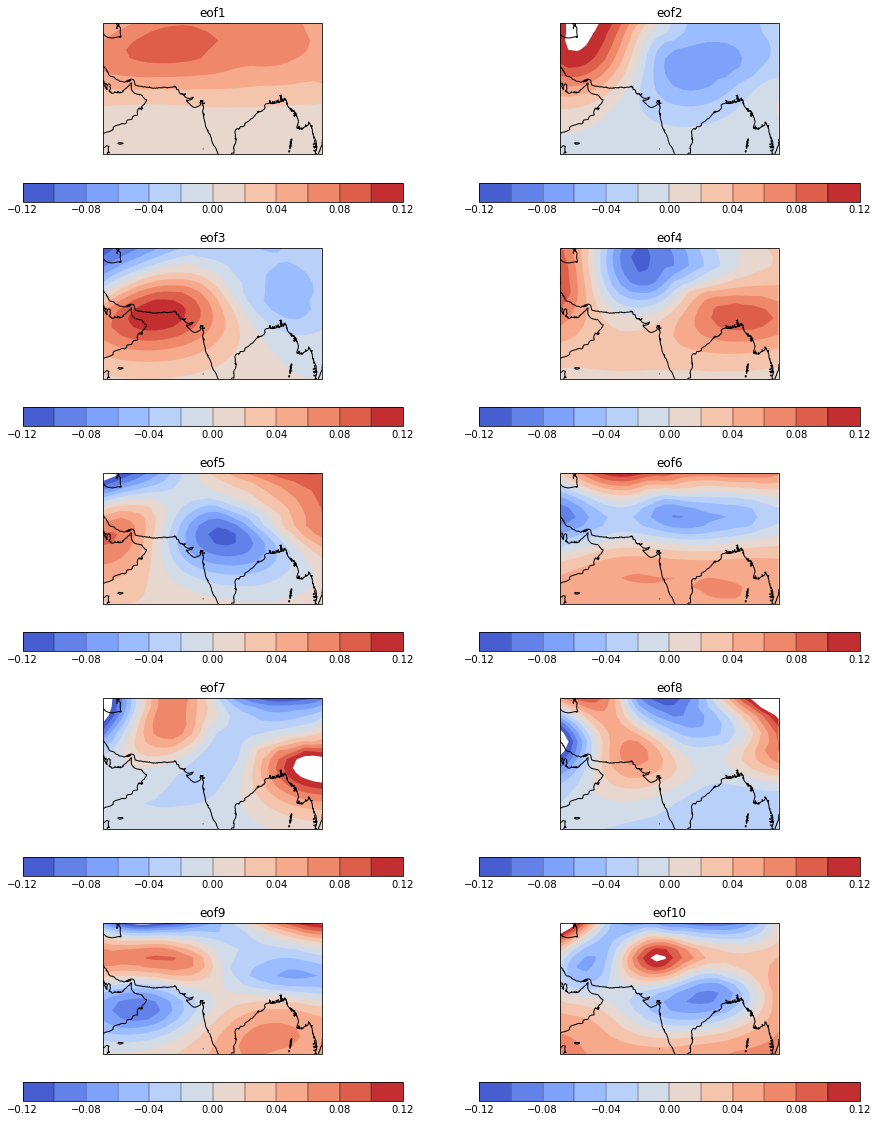

In [30]:
# get WFD daily anomaly
wfdZ=decJanAnomz.sel(latitude=slice(40,10),longitude=slice(50,100))[yAll >0.44,:,:]
solver = Eof(wfdZ)

# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof = solver.eofs(neofs=10)
eof


variance_fractions = solver.varianceFraction(neigs=10)
print(variance_fractions.sum())
print(variance_fractions)

# plot eofs
#levels = (-60,-50,-40,-30,-20, -10,0,10,20,30,40,50,60)
levels = (-0.12,-0.1,-0.08,-0.06,-0.04, -0.02,0,0.02,0.04,0.06,0.08,.1,0.12)
# Plot #1: contourf with axes longitude from -180 to 180
eof1=eof[0,:,:].to_iris()
plt.figure(figsize=(15,20))
plt.subplot(521)
qplt.contourf(eof1,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof1")

eof2=eof[1,:,:].to_iris()
plt.subplot(522)
qplt.contourf(eof2, cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof2")


eof3=eof[2,:,:].to_iris()
plt.subplot(523)
qplt.contourf(eof3,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof3")

eof4=eof[3,:,:].to_iris()
plt.subplot(524)
qplt.contourf(eof4,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof4")


eof5=eof[4,:,:].to_iris()
plt.subplot(525)
qplt.contourf(eof5,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof5")

eof6=eof[5,:,:].to_iris()
plt.subplot(526)
qplt.contourf(eof6,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof6")


eof7=eof[6,:,:].to_iris()
plt.subplot(527)
qplt.contourf(eof7,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof7")

eof8=eof[7,:,:].to_iris()
plt.subplot(528)
qplt.contourf(eof8, cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof8")


eof9=eof[8,:,:].to_iris()
plt.subplot(529)
qplt.contourf(eof9,  cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof9")

eof10=eof[9,:,:].to_iris()
plt.subplot(5,2,10)
qplt.contourf(eof10, cmap='coolwarm',levels=levels)
plt.gca().coastlines()
plt.title("eof10")

iplt.show()



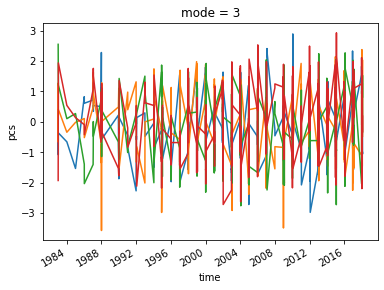

In [18]:
pc=solver.pcs(npcs=10, pcscaling=1)
pc[:,0].plot()
pc[:,1].plot()
pc[:,2].plot()
pc[:,3].plot()